In [79]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## na koncu naredi search za LINK in najdi vsa mesta kjer moraš vstatiti notri link!

# LOAD FORECASTING - How to develop a benchmark model?

### This notebook was created by Miha Grabner.
#### If you want to see more please visit [mihagrabner.com](https://www.mihagrabner.com/) or a LinkedIn group [AI in Smart Grids](https://www.linkedin.com/groups/13621702/).
#### If you like my work please share it with other!

# NOTEBOOK DESCRIPTION
In this notebook, I will guide you through load forecasting [benchmark model](https://ieeexplore.ieee.org/abstract/document/6038881) development based on Multiple Linear Regression. This model was also used at Global Energy Forecasting Competitions (GefCom) as a baseline model. I will explain the basics behind the feature engineering step by step.  <br>

##### How to model the load with Multiple Linear Regression (MLR)?
MLR is the most widely used method for load forecasting and achieves remarkable results in industry and on load forecasting competitions. Despite the fact that MLR as an algorithm is very easy and simple to understand at first, modeling various problems is not that straight-forward. You cannot just put something into the model as with Neural Networks and expect it to magically work. <br>
MLR is a linear model, but this does not mean you cannot model non-linear dependencies. All you need is an appropriate feature engineering in order to linearize the problem. <br>

Prerequests for fully understand this notebook:
1. I strongly suggest reading at least first 120 pages of an excellent and free book: [An Introduction to Statistical Learning](http://faculty.marshall.usc.edu/gareth-james/ISL/). <br>
2. If you haven't watched [Andrew Ng's ML course](https://www.coursera.org/learn/machine-learning?), you have to watch it now. Watch at least first part about MLR. <br>
3. [This book can help if you are a beginner](https://www.amazon.com/Introduction-Machine-Learning-Python-Scientists/dp/1449369413).

# LIBS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = "w"

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

# IMPORT DATA

Input data consist of a load time series in MW from 2013-1-1 until 2017-12-31 with hourly resolution and a temperature in °C for the same time period.

In [2]:
# INPUT DATA
ts = (pd.read_csv("load.csv", index_col=["timestamp"], parse_dates=True)
        .iloc[:, 0].rename("load"))

temp = (pd.read_csv("temperature.csv", index_col=["timestamp"], parse_dates=True)
          .iloc[:, 0].rename("temp"))

# SAVE TARGET AS y
y = ts.rename("y").copy()

# GET COLORS
blue = sns.color_palette("muted", desat=0.9)[0]
green = sns.color_palette("muted", desat=0.9)[2]
red = sns.color_palette("muted", desat=0.9)[3]
grey = sns.color_palette("muted", desat=0.9)[7]

ts.head(2)

timestamp
2013-01-01 00:00:00    16.4
2013-01-01 01:00:00    16.1
Name: load, dtype: float64

Let's plot our load time series together with 30-day moving average in order to observe seasonal variations and trend.

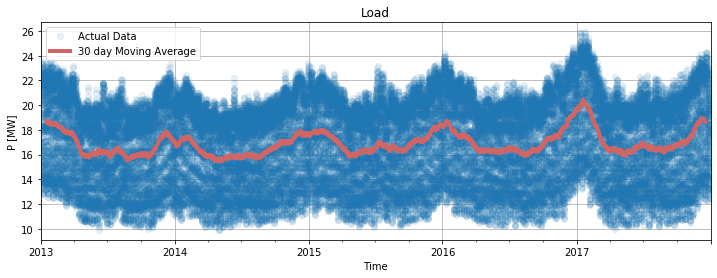

In [82]:
ts.plot(figsize=[12, 4], alpha=0.1, marker="o", linestyle="");
ts.rolling(window=30*24, center=True).mean().plot(ax=plt.gca(), color=red, lw=4);
plt.legend(["Actual Data", "30 day Moving Average"])
plt.grid()
plt.xticks(), plt.yticks();
plt.xlabel("Time"), plt.ylabel("P [MW]");
plt.title("Load");

# FEATURE ENGINEERING

Typical features used for load forecasting are:
- categorical features derived from timestamps and
- numericaL features: 
    - temperature (or some other weather variables) and 
    - past load (in case of short-term forecasting)

As I mentioned in my previous blog on Exploratory Data Analysis (LINK?), load depends on three major factors:
- calendar (the hour of the day, day of the week and time of the year).
- weather (especially temperature, this is due to heating and cooling devices).
- economic growth (load generally grows every year).

<br>
Now, let's follow the assumptions above and explore how to model this with MLR. In further examples we will use the whole dataset (no train/test splitting) in order to simply explanations and understand how to learn/capture a load time series data with MLR.

**The notebook is divided in three major chapters:**
    1. modeling calendar features, 
    2. modeling temperature and 
    3. modeling trend.

## Helper Functions & all the Features used in the following notebook

For now, run the cell below and skip to chapter 1. modeling calendar features. You can come back later and break down the code.

In [3]:
def get_season(ts_in):
    season = pd.Series()

    for year in ts_in.index.year.unique():

        # CREATE SEASONS
        yearly_season = pd.Series("inter-season", index=ts_in.loc[str(year)].index)

        yearly_season.loc[: "{}-2-15".format(year)] = "winter"
        yearly_season.loc["{}-11-15".format(year) :] = "winter"
        yearly_season.loc["{}-5-15".format(year) : "{}-9-15".format(year)] = "summer"

        season = pd.concat([season, yearly_season])
    return season


def get_interactions(s, dummies, poly_degree=1):
    """
    Description:
    Calculates interaction between numerical feature and dummy variables.
    
    Input:
    s (pd.Series): numerical feature
    dummies (pd.Series or pd.DataFrame): Boolean features representing dummy variables.
    
    Output:
    df (pd.DataFrame): calculated interactions together with polynomials (in case poly_degree > 1) between
                       numerical feature and categorical dummy features.
    """
    
    
    if s.name == None: s.name = "_"
    s1 = dummies.apply(lambda x: x * s).rename("{}".format(s.name + "_{}").format, axis=1)
    s2 = (dummies.apply(lambda x: x * s) **2).rename("{}".format(s.name + "2_{}").format, axis=1)
    s3 = (dummies.apply(lambda x: x * s) **3).rename("{}".format(s.name + "3_{}").format, axis=1)
    
    if poly_degree == 1: s2, s3 = None, None
    if poly_degree == 2: s3 = None

    df = pd.concat([s1, s2, s3], axis=1)
    return df


def print_mape(y_true, y_pred):
    error = y_true - y_pred
    mape = (100 * error.abs() / y_true).mean()
    print("MAPE: {:.3f} %".format(mape))
    

season = get_season(y).rename("season")
month = pd.Series(y.index.month.astype(str), index=y.index, name="month").apply(lambda x: "m{}".format(x))
day = pd.Series(y.index.dayofweek.astype(str), index=y.index, name="day").apply(lambda x: "d{}".format(x))
hour = pd.Series(y.index.strftime("%H:%M"), index=y.index, name="hour")
dayhour = (day + "_" + hour).rename("dayhour")

month_dummies = pd.get_dummies(month.sort_values()).sort_index()
day_dummies = pd.get_dummies(day.sort_values()).sort_index()
hour_dummies = pd.get_dummies(hour.sort_values()).sort_index()
dayhour_dummies = pd.get_dummies(dayhour.sort_values()).sort_index()

trend = pd.Series(np.arange(1, len(y) + 1), y.index, name="trend")

# 1. MODELING CALENDAR FEATURES

## Features used: only constant

In most cases in machine learning, you want to minimize Residual Sum of Squares. This means, that in case you are searching for a single value that will minimize this criteria in your model, this value would be a mean target value. Let's look what this means. <br>
Target value which is load is saved as y.

Let's build a dataset matrices X and y and use only one constant feature to build our model and set fit_intercept to false (because sklearn fits intercept by default and adds a constant).

In [84]:
X_arr = np.ones_like(y).reshape(-1, 1) # create 
y_arr = y.values.reshape(-1, 1)
print("X dimensions: {}, y dimensions: {}".format(X_arr.shape, y_arr.shape))

mlr = LinearRegression(fit_intercept=False).fit(X_arr, y_arr)
np.unique(mlr.predict(X_arr))

X dimensions: (43824, 1), y dimensions: (43824, 1)


array([16.94410369])

Below you can see that the result equals to a mean target value.

In [85]:
y.mean()

16.94410368747718

Remember that when minimizing Residual Sum of Squares which is the same as minimizing Mean Squared Error a single value that will minimize this criteria in your model is a mean target value. In case of minimizing Mean Absolute Error it is median.

## Features used: hours of the day
- without intercept and dummy dropping

Now, let's try using only hours of the day as features in our model. This time we will not fit a constant and we will also not drop one dummy variable (will be explained later). <br>
What do we learn now?

In [86]:
# CREATE FEATURES
X_arr = hour_dummies.values
y_arr = y.values.reshape(-1, 1)
print("X dimensions: {}, y dimensions: {}".format(X_arr.shape, y_arr.shape))

mlr = LinearRegression(fit_intercept=False).fit(X_arr, y_arr)
y_pred = pd.Series(mlr.predict(X_arr).flatten(), index=y.index, name="y_pred")
y_pred_hour = y_pred.copy()  # for later comparison
print_mape(y, y_pred)

y_pred.head(2)

X dimensions: (43824, 24), y dimensions: (43824, 1)
MAPE: 9.125 %


timestamp
2013-01-01 00:00:00    12.973877
2013-01-01 01:00:00    12.395071
Name: y_pred, dtype: float64

Now, instead of using MLR, we can calculate mean target value for every hour separately using pivot_table.

In [87]:
y_hourly_mean = pd.pivot_table(y.to_frame(), index=y.index.hour).y
y_pred_hourly_mean = pd.Series(y.index.hour, index=y.index, name="y_pred_hourly_mean").map(y_hourly_mean).sort_index()

Look at the magic below, result is the same as with MLR! <br>
This is very important to understand and I suggest you keep this in mind!

In [88]:
(y_pred - y_pred_hourly_mean).mean()

-8.141635513917814e-16

Now, let's plot the prediction and the target for a randomly chosen week and observe the predicted profile.

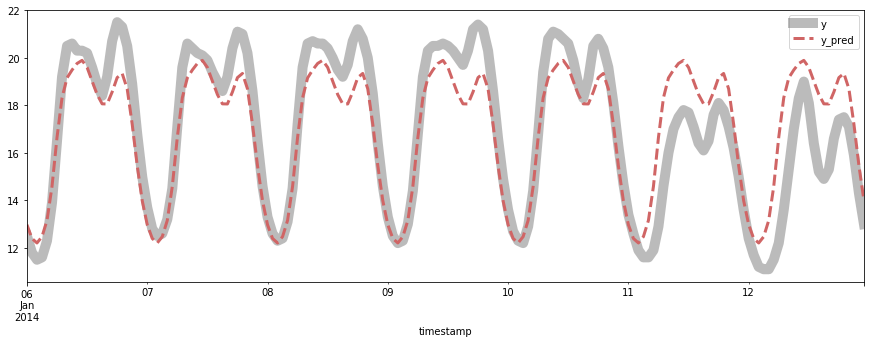

In [89]:
indices = y["2014-1-6": "2014-1-12"].index

y.loc[indices].plot(figsize=[15, 5], lw=10, alpha=0.5, color=grey, legend=True);
y_pred.loc[indices].plot(lw=3, ls="--", color=red, legend=True);

The model can not capture anything else than the hour of the day, which results in average behavior during the whole time. When actual profiles are above average, predicted will be below and vice versa. It can be clearly seen that during the working days (6 until 10 Janurary) when the demand is usually higher predictions are lower than actual demand and vice versa during weekends (11 and 12 Janurary).

Since the model can not distinguish between different months, neither days this leads to the same daily predictions during the whole time.

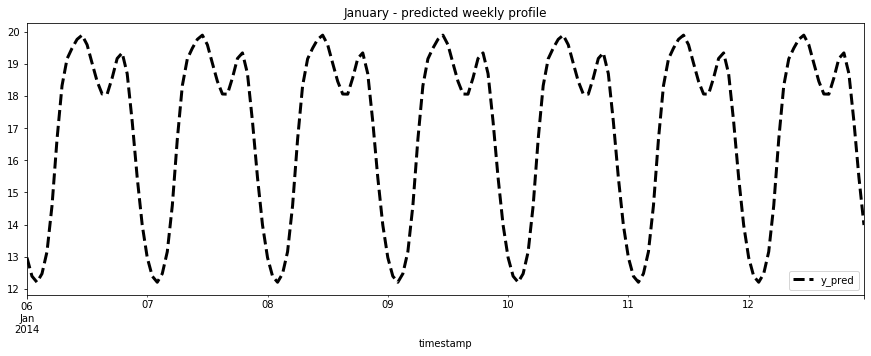

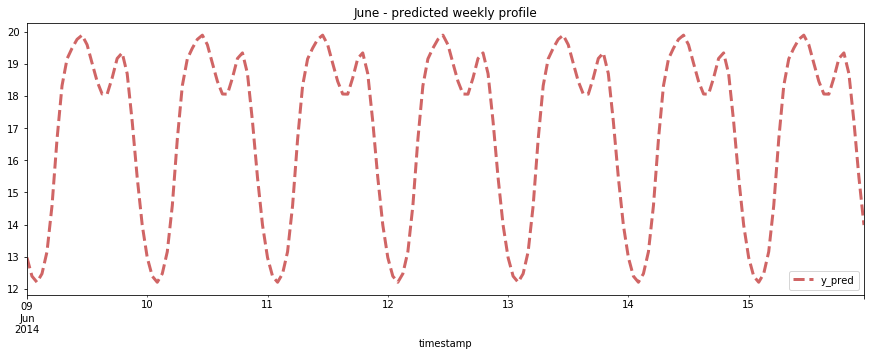

In [90]:
indices_january = y["2014-1-6": "2014-1-12"].index
indices_june = y["2014-6-9": "2014-6-15"].index


fig = plt.figure(figsize=[15, 5])
y_pred_hour.loc[indices_january].plot(lw=3, ls="--", color="k", legend=True);
plt.title("January - predicted weekly profile")

fig = plt.figure(figsize=[15, 5])
y_pred_hour.loc[indices_june].plot(lw=3, ls="--", color=red, legend=True);
plt.title("June - predicted weekly profile");

### What about colinearity and dropping one dummy?
When modeling categorical features with dummy variables one category has to be dropped in order to avoid colinearity or do not use a constant by setting fit_intercept=False. We will obey this in further calculations.

## Features used: month + day of the week + hour of the day

Now, let's add dummy variables for months, day types and hours so that our model will able to incorporate it.

In [91]:
# CREATE FEATURES
X = pd.concat([month_dummies.iloc[:, :-1],  # exclude the last category
               day_dummies.iloc[:, :-1],    # exclude the last category
               hour_dummies.iloc[:, :-1]    # exclude the last category
              ], axis=1)
X_arr = X.values
y_arr = y.values.reshape(-1, 1)
print("X dimensions: {}, y dimensions: {}".format(X_arr.shape, y_arr.shape))

mlr = LinearRegression().fit(X_arr, y_arr)
y_pred = pd.Series(mlr.predict(X_arr).flatten(), index=y.index, name="y_pred")
y_pred_mdh = y_pred.copy()  # for later comparison
print_mape(y, y_pred)

y_pred.head(2)

X dimensions: (43824, 40), y dimensions: (43824, 1)
MAPE: 5.877 %


timestamp
2013-01-01 00:00:00    15.329041
2013-01-01 01:00:00    14.750235
Name: y_pred, dtype: float64

It can be seen that MAPE improves significantly. With the above added features, model is able to learn one parameter for every month, day type and hour separately which also impacts the daily shape of predicted profiles.

## Features used: month + day of the week x hour of the day

Now, let's add dummy variables for months and use interaction between day types and hours. If we model the day of the week and hour of the day as in previous section we can model this behavior with 7 + 24 = 31 parameters (before dropping last dummies). <br>
In case of using interactions between day of the week and hours, this behavior is modeled with 7 x 24 = 168 parameters (before dropping last dummies), which is much more and leads to modeling a particular hour on a particular day separately. <br>
TIP: investigate the difference between dataframes day_dummies, hour_dummies & dayhour_dummies and you will understand it.

In [92]:
# CREATE FEATURES
X = pd.concat([month_dummies.iloc[:, :-1],  # exclude the last category
               dayhour_dummies.iloc[:, :-1],    # exclude the last category
              ], axis=1)
X_arr = X.values
y_arr = y.values.reshape(-1, 1)
print("X dimensions: {}, y dimensions: {}".format(X_arr.shape, y_arr.shape))

mlr = LinearRegression().fit(X_arr, y_arr)
y_pred = pd.Series(mlr.predict(X_arr).flatten(), index=y.index, name="y_pred")
y_pred_mdxh = y_pred.copy()  # for later comparison
print_mape(y, y_pred)

y_pred.head(2)

X dimensions: (43824, 178), y dimensions: (43824, 1)
MAPE: 4.669 %


timestamp
2013-01-01 00:00:00    14.792275
2013-01-01 01:00:00    14.233272
Name: y_pred, dtype: float64

It can be seen that MAPE improves again.

## Comparing profiles learned with different models

Let's try comparing daily profile shapes learned by different models.

In [93]:
preds = pd.concat([y_pred_hour.rename("hour"),
                   y_pred_mdh.rename("month + day + hour"),
                   y_pred_mdxh.rename("month + day x hour")
                  ], axis=1)

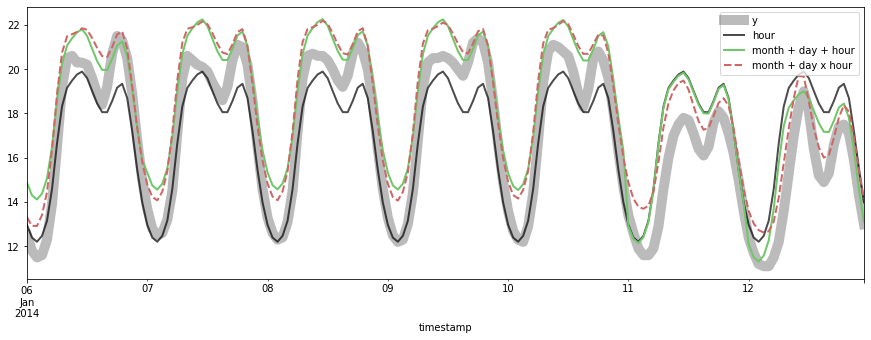

In [94]:
indices = y["2014-1-6": "2014-1-12"].index

y.loc[indices].plot(figsize=[15, 5], lw=10, alpha=0.5, color=grey, legend=True);
preds.loc[indices, "hour"].plot(lw=2, ls="-", color="k", alpha=0.7, legend=True);
preds.loc[indices, "month + day + hour"].plot(lw=2, ls="-", color=green, legend=True);
preds.loc[indices, "month + day x hour"].plot(lw=2, ls="--", color=red, legend=True);

I suggest you to try further comparing predicted profiles during different times of the year in order to clearly understand the difference in predictions.

# 2. MODELING TEMPERATURE

The correlation between the load and the temperature is below. To understand it, first take a look at my previous blog on Exploratory Data Analysis (LINK??)

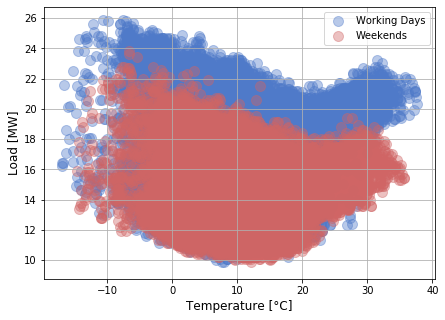

In [95]:
s = 100

fig = plt.figure(figsize=[7, 5])

plt.scatter(x=temp[ts.index.dayofweek < 5], 
            y=ts[ts.index.dayofweek < 5], alpha=0.4, s=s, color=blue);
plt.scatter(x=temp[ts.index.dayofweek >= 5], 
            y=ts[ts.index.dayofweek >= 5], alpha=0.4, s=s, color=red);
plt.grid()
plt.xlabel("Temperature [°C]", fontsize=12), 
plt.ylabel("Load [MW]", fontsize=12);
plt.legend(["Working Days", "Weekends"]);

How to model this with MLR? <br>
First, you have to understand the concept of piece-wise linear regression. I suggest reading [this chapter](https://github.com/amueller/introduction_to_ml_with_python/blob/master/04-representing-data-feature-engineering.ipynb) from an [excellent book](https://www.amazon.com/Introduction-Machine-Learning-Python-Scientists/dp/1449369413).

### Let's create an artificial dataset
In the next few sections I will guide you step by step through piece-wise and polynomial linear regression modeling. Let's create an artificial dataset and learn it back with MLR.

In a supervised learning task the formulation is as follows:
$y_{true}$ = $y_{pred}$ + $random\_gaussian\_noise$ <br>

Using the formula above, we can create a function and add it some noise to build our dataset. We will do this in a following lines.

Here x will represent a single feature and y is a target variable. <br>
We want to predict y, given x. 

In [96]:
# CREATE SOME RANDOM DATA (create piece-wise quadratic function and add Gaussian noise)
x_arr = np.arange(0, 4, 0.01).reshape(-1, 1)
y_arr = np.zeros_like(x_arr)

x = pd.Series(x_arr.flatten())

threshold = 2
np.random.seed(0)
y_arr[x_arr < threshold] = 1.5 * x_arr[x_arr < threshold] ** 2 - 4 * x_arr[x_arr < threshold] + np.random.normal(scale=1, size=len(x_arr[x_arr < threshold]))
y_arr[x_arr >= threshold] = 0.5  * x_arr[x_arr >= threshold] ** 2 - 1 + np.random.normal(scale=1, size=len( x_arr[x_arr >= threshold])) 

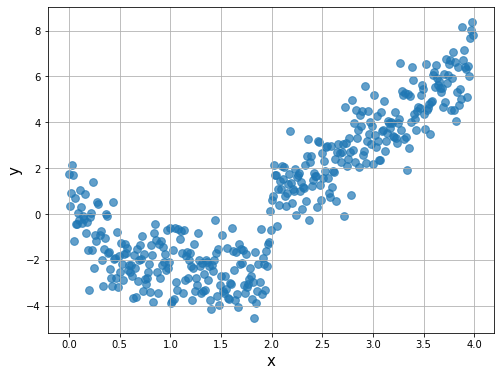

In [97]:
fig = plt.figure(figsize=[8, 6], facecolor="w")
plt.scatter(x=x_arr, y=y_arr, s=60, alpha=0.7);
plt.grid()
plt.xlabel("x", fontsize=15), plt.ylabel("y", fontsize=15);

## Modeling with one parameter

First, let's try modeling the correlation using the original feature. As this correlation is not linear, our model fails to capture the data.

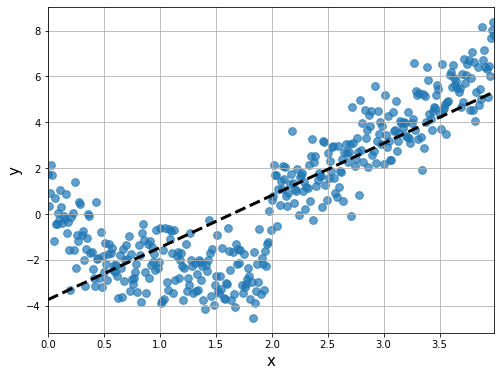

In [98]:
X = pd.concat([x
              ], axis=1)
X_arr = X.values.reshape(-1, 1)

mlr = LinearRegression().fit(X_arr, y_arr)
y_pred = pd.Series(mlr.predict(X_arr).flatten(), index=x, name="prediction")

fig = plt.figure(figsize=[8, 6], facecolor="w")
plt.scatter(x=x_arr, y=y_arr, s=60, alpha=0.7);
y_pred.plot(lw=3, ls="--", color="k")
plt.grid()
plt.xlabel("x", fontsize=15), plt.ylabel("y", fontsize=15);

## Segmentation of numerical feature into two features
Intead of modeling a problem with original numerical feature x, we create two features from a original feature by adding a knot at 2, since we can see that data changes there. <br>
This is actually the same as modeling interaction of one numerical feature with one categorical feature. <br>
These two features (x_left & x_right) are created from a original feature, whereas one is defined only on a left side and another only on the right side of x-axis, otherwise it equals to zero.

In [99]:
x_left, x_right = x.rename("x_left").copy(), x.rename("x_right").copy()
x_left.loc[x > 2] = 0
x_right.loc[x <= 2] = 0

X = pd.concat([x_left, x_right, 
              ], axis=1)
X_arr = X.values

X.head()

,x_left,x_right
0,0.00,0.0
1,0.01,0.0
2,0.02,0.0
3,0.03,0.0
4,0.04,0.0


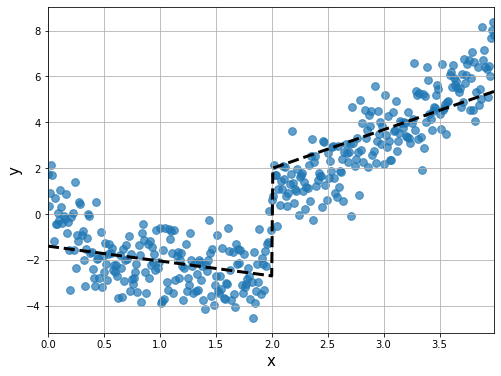

In [100]:
mlr = LinearRegression().fit(X_arr, y_arr)
y_pred = pd.Series(mlr.predict(X_arr).flatten(), index=x, name="prediction")

fig = plt.figure(figsize=[8, 6], facecolor="w")
plt.scatter(x=x_arr, y=y_arr, s=60, alpha=0.7);
y_pred.plot(lw=3, ls="--", color="k")
plt.grid()
plt.xlabel("x", fontsize=15), plt.ylabel("y", fontsize=15);

Above it can be seen, that the model fits the data much better than before.

## Adding 2nd degree polynomial

Another important thing to understand is polynomial regression, where we add polynomials of the original feature to the model. Let's add a square, so that we are able to model quadratic function.

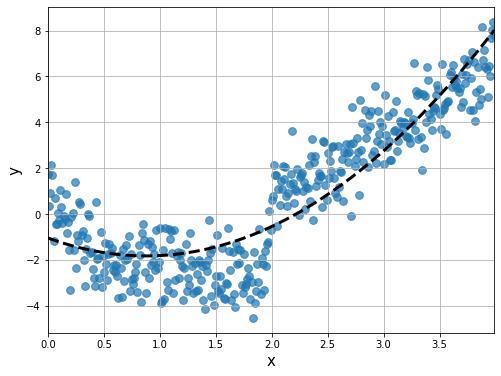

In [101]:
X = pd.concat([x, x ** 2
              ], axis=1)
X_arr = X.values

mlr = LinearRegression().fit(X_arr, y_arr)
y_pred = pd.Series(mlr.predict(X_arr).flatten(), index=x, name="prediction")

fig = plt.figure(figsize=[8, 6], facecolor="w")
plt.scatter(x=x_arr, y=y_arr, s=60, alpha=0.7);
y_pred.plot(lw=3, ls="--", color="k")
plt.grid()
plt.xlabel("x", fontsize=15), plt.ylabel("y", fontsize=15);

We can see, that the model fits the data quite better than originally with only one feature.

## Adding 2nd degree polynomial with segmentation

And finally let's combine piece-wise and polynomial regression by adding 2nd degree polynomial and segmenting it! <br>
Look at the magic! <br>
#### If you truly understand this, you will be able to model the correlation between the load and the temperature!

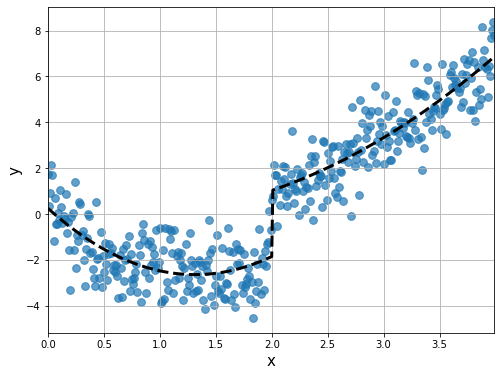

In [102]:
x_left, x_right = x.rename("x_left").copy(), x.rename("x_right").copy()
x_left.loc[x > 2] = 0
x_right.loc[x <= 2] = 0


X = pd.concat([x_left, x_left ** 2, 
               x_right, x_right ** 2
              ], axis=1)
X_arr = X.values

mlr = LinearRegression().fit(X_arr, y_arr)
y_pred = pd.Series(mlr.predict(X_arr).flatten(), index=x, name="prediction")

fig = plt.figure(figsize=[8, 6], facecolor="w")
plt.scatter(x=x_arr, y=y_arr, s=60, alpha=0.7);
y_pred.plot(lw=3, ls="--", color="k")
plt.grid()
plt.xlabel("x", fontsize=15), plt.ylabel("y", fontsize=15);

Now, you can compare original coefficients from where the data was sampled with learned ones:

In [103]:
mlr.coef_

array([[-4.39957372,  1.67392934, -0.88378389,  0.63674132]])

They are not excatly the same, as we added some random Gaussian noise to the original function, but they are quite close. <br>
It is very important to understand how to artificially generate a data and then learn it back. It truly deepens your understanding.

Next, we will use the knowledge about piece-wise and polynomial linear regression to add a temperature to our existing model.

## Features used: <br>
($temp$ x $month$ + $temp^{2}$ x $month$ + $temp^{3}$ x $month$) + ($temp$ x $hour$ + $temp^{2}$ x $hour$ + $temp^{3}$ x $hour$) + $month$ + $day\_of\_the\_week$ x $hour\_of\_the\_day$)

Load and temperature correlation changes during the year (different seasons) and is different between various hours of the day. E.g.: correlation is not the same during the night time when people sleep, than during the day time. For detailed understanding look at the previous blog about Exploratory Data Analysis (LINK?). <br>
Since we want to capture non-linear dependencies, we also add 3rd degree polynomials. Why 3rd and not 2nd? Because 2nd degree polynomial or quadratic function is symmetrical as opposed to 3rd that can model asymmetrical dependencies. <br>

To model different load-temperature correlations between months and hours, we add two sets of features:
- interaction between temperature with monthly dummies and corresponding 3rd degree polynomials &
- interaction between temperature with hourly dummies and corresponding 3rd degree polynomials.

In [104]:
# CREATE FEATURES
X = pd.concat([month_dummies.iloc[:, :-1],  # exclude the last category
               dayhour_dummies.iloc[:, :-1],    # exclude the last category
               
               get_interactions(temp, month_dummies, poly_degree=3),  # month interactions
               get_interactions(temp, hour_dummies, poly_degree=3)   # hourly interactions
              ], axis=1)
X_arr = X.values
y_arr = y.values.reshape(-1, 1)
print("X dimensions: {}, y dimensions: {}".format(X_arr.shape, y_arr.shape))

mlr = LinearRegression().fit(X_arr, y_arr)
y_pred = pd.Series(mlr.predict(X_arr).flatten(), index=y.index, name="y_pred")
y_pred_mdxh = y_pred.copy()  # for later comparison
print_mape(y, y_pred)

y_pred.head(2)

X dimensions: (43824, 286), y dimensions: (43824, 1)
MAPE: 3.553 %


timestamp
2013-01-01 00:00:00    14.501890
2013-01-01 01:00:00    13.561124
Name: y_pred, dtype: float64

As you can see above, MAPE significantly improves, by adding a temperature into the model.

# 3. MODELING TREND
Electricity load generally grows every year due to economic growth and we have to incorporate this in a model.
Why? Assuming that behavior throughout the observed time span stays the same, load still increases a little bit. <br>
Trend is a general systematic linear or nonlinear component that changes over time and does not repeat.
The easiest way to model trend is by adding additional feature $trend$ that assigns a natural number to each observation starting from first timestamp to the end.

Now, let's add feature trend to our existing model and observe the performance.

In [105]:
# CREATE FEATURES
X = pd.concat([month_dummies.iloc[:, :-1],  # exclude the last category
               dayhour_dummies.iloc[:, :-1],    # exclude the last category
               
               get_interactions(temp, month_dummies, poly_degree=3),  # month interactions
               get_interactions(temp, hour_dummies, poly_degree=3),   # hourly interactions
               
               trend
              ], axis=1)
X_arr = X.values
y_arr = y.values.reshape(-1, 1)
print("X dimensions: {}, y dimensions: {}".format(X_arr.shape, y_arr.shape))

mlr = LinearRegression().fit(X_arr, y_arr)
y_pred = pd.Series(mlr.predict(X_arr).flatten(), index=y.index, name="y_pred")
y_pred_mdxh = y_pred.copy()  # for later comparison
print_mape(y, y_pred)

y_pred.head(2)

X dimensions: (43824, 287), y dimensions: (43824, 1)
MAPE: 3.463 %


timestamp
2013-01-01 00:00:00    14.21160
2013-01-01 01:00:00    13.28962
Name: y_pred, dtype: float64

By adding trend, the performance improves a little bit.

### Congratulation you have built the first MLR load forecasting model.

**Suggestion:** everytime you start with a load forecasting problem, first apply this benchmark and then start improving this model. There are a lot things that can be improved. <br>
You can also use this code and try new features to further improve the performance.